In [1]:
## System
import sys
import os
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Fig utils 
from fig_utils import (get_decile_score, 
                       deciles, 
                       OR_color,
                       AR_color,
                       AD_color,
                       HI_color,
                       NonEss_color)


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
ConSplice_df = pd.read_csv(genic_consplice_file, sep = "\t", index_col = False)

In [5]:
## Load gene sets

hi_genes = "../data/HI.genes.tsv"
with open(hi_genes) as hg:
    haploinsufficient_genes = [x.strip() for x in hg]

autosomaldominant_genes = "../data/AD.genes.tsv"
with open(autosomaldominant_genes) as ad:
    ad_genes = [x.strip() for x in ad]
    
autosomalrecessive_genes = "../data/AR.genes.tsv"
with open(autosomalrecessive_genes) as ar:
    ar_genes = [x.strip() for x in ar]
    
olfactoryreceptor_genes = "../data/OR.genes.tsv"
with open(olfactoryreceptor_genes) as org:
    or_genes = [x.strip() for x in org]
    

## Load CRISPR gene sets
crispr_non_essentail_genes = "../data/CRISPR.Nonessential.genes.tsv"
with open(crispr_non_essentail_genes) as cneg:
    crispr_non_essentail = [x.strip() for x in cneg]

In [6]:
## Create new df with gene info 

new_df_list = []

new_df_list.extend([[gene,"Haploinsufficient"] for gene in haploinsufficient_genes])
new_df_list.extend([[gene,"Autosomal Dominant"] for gene in ad_genes])
new_df_list.extend([[gene,"Autosomal Recessive"] for gene in ar_genes])
new_df_list.extend([[gene, "Olfactory Genes"] for gene in or_genes])
new_df_list.extend([[gene,"CRISPR Non-Essential"] for gene in crispr_non_essentail])

gene_list_df = pd.DataFrame(new_df_list, columns = ["gene","gene_list"])

del new_df_list

In [7]:
## Add ConSplice scores to gene df

o_e_gene_set = set(ConSplice_df.gene_symbol)
gene_list_df["ConSplice"] = gene_list_df.gene.apply(lambda x: ConSplice_df.loc[ConSplice_df.gene_symbol == x][consplice_col].values[0] if x in o_e_gene_set else "Missing" )

In [8]:
gene_list_df.groupby("gene_list").describe()

gene                     ConSplice                     
                     count unique     top freq     count unique      top freq
gene_list                                                                    
Autosomal Dominant     709    709  CYP2C9    1       709    643  Missing   67
Autosomal Recessive   1183   1183   TACR1    1      1183   1083  Missing  101
CRISPR Non-Essential   913    913   ELOA2    1       913    660  Missing  254
Haploinsufficient      294    294    PAX2    1       294    188  Missing  107
Olfactory Genes        371    371  OR2AG2    1       371    180  Missing  192

In [9]:
## Bin scores and normalize counts

gene_list_df["constraint_decile"] = gene_list_df.ConSplice.apply(get_decile_score)

normalized_gene_list_df = gene_list_df.loc[gene_list_df.constraint_decile != "None"].groupby("gene_list")["constraint_decile"].value_counts(normalize=True).reset_index(name='percentage')

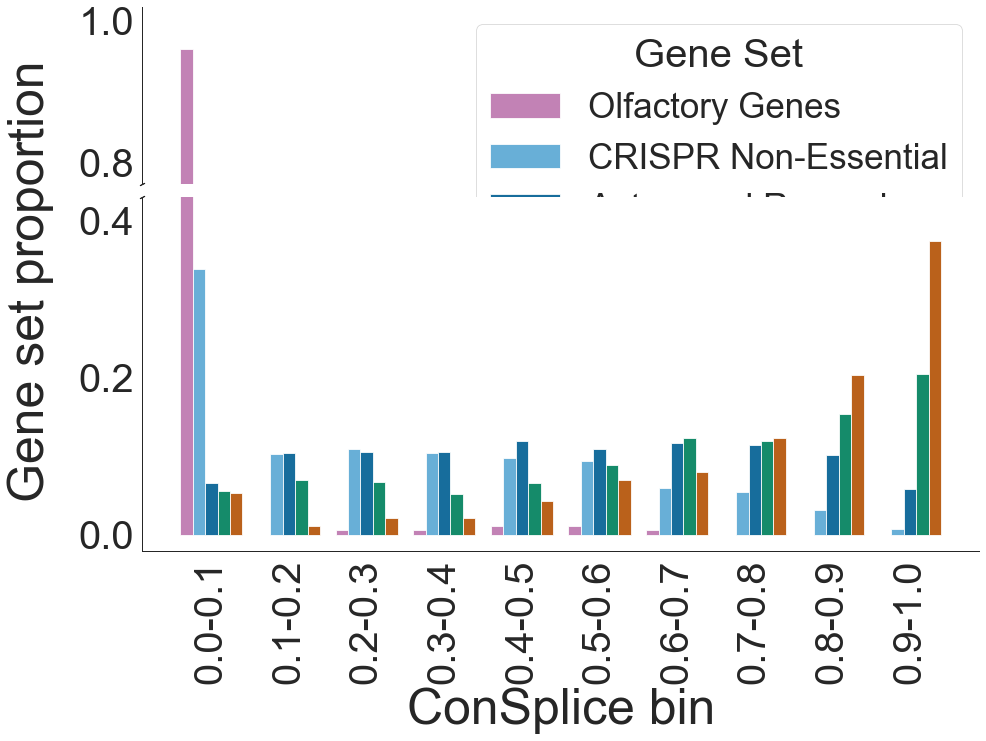

In [11]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]}, sharex=True, figsize = (15,10))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

hue_order = ["Olfactory Genes","CRISPR Non-Essential","Autosomal Recessive","Autosomal Dominant","Haploinsufficient"]

bplot = sns.barplot(data = normalized_gene_list_df, 
            x = "constraint_decile", 
            y = "percentage", 
            hue = "gene_list",
            hue_order = hue_order,
            order = deciles,
            palette = [OR_color,
                       NonEss_color,
                       AR_color,
                       AD_color,
                       HI_color],
            ax = ax1,)

bplot = sns.barplot(data = normalized_gene_list_df, 
            x = "constraint_decile", 
            y = "percentage", 
            hue = "gene_list",
            hue_order = hue_order,
            order = deciles,
            palette = [OR_color,
                       NonEss_color,
                       AR_color,
                       AD_color,
                       HI_color],
            ax = ax2,)


ax1.set_ylim(0.77,1.02)
ax2.set_ylim(-0.02,0.43)

ax1.set_ylabel("")
ax1.set_xlabel("")

ax2.set_ylabel("")


fig.text(0.0, 0.5, 'Gene set proportion', va='center', rotation='vertical', fontsize = 50)

ax2.set_xlabel("ConSplice bin", fontsize = 50)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.tick_params(labeltop=False)  # don't put tick labels at the top

ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 0], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.axhline(1, ls='--', color = "black")
ax2.legend().set_visible(False)
ax1.tick_params(axis="x", labelsize=40, )
ax1.tick_params(axis="y", labelsize=40)   
ax2.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=40, rotation = 90, )
ax2.tick_params(axis="y", labelsize=40)   
ax1.legend(title = "Gene Set", fontsize = 35, title_fontsize = 40, loc = "upper right")

plt.savefig('../figures/figure2_A.svg')